In [1]:
! nvidia-smi -L

GPU 0: Tesla P4 (UUID: GPU-dedd9229-aef9-a9fa-89a2-18d60da38a63)


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models

from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop, SGD
from keras.utils import np_utils
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')


In [3]:
#Define learning rate
'''
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 50:
        lrate = 0.0005
    elif epoch > 75:
        lrate = 0.0003        
    return lrate
'''
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 50:
        lrate = 0.0005
    if epoch > 75:
        lrate = 0.0003
    elif epoch > 100:
        lrate = 0.0001        
    return lrate

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

img_rows, img_cols = 32, 32
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
 
print ("x_train: ", x_train.shape)
print ("y_train: ", y_train.shape)
print ("x_test: ", x_test.shape)
print ("x_test: ", y_test.shape)
 

170500096/170498071 [==============================] - 2s 0us/step
x_train:  (50000, 32, 32, 3)
y_train:  (50000, 1)
x_test:  (10000, 32, 32, 3)
x_test:  (10000, 1)


In [5]:
# Parse numbers as floats
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [6]:
# Normalize pixel values to be between 0 and 1
x_train /= 255.0
x_test /= 255.0

In [7]:
num_classes = 10
#convert array of labeled data to one-hot vector.
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)


In [8]:
#Create the model
weight_decay = 1e-4

#Layer1: BatchNormalization
model = Sequential()
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())

#Layer2: BatchNormalization+MaxPooling+Dropout(0.2)
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

#Layer3: BatchNormalization
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())

#Layer4: BatchNormalization+MaxPooling+Dropout(0.3)
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

#Layer5: BatchNormalization
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())

#Layer6: BatchNormalization+MaxPooling+Dropout(0.4)
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

#Layer7: BatchNormalization
model.add(Conv2D(256, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())

#Layer8: BatchNormalization+MaxPooling+Dropout(0.5)
model.add(Conv2D(256, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

#### Data preprocessing 

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0

In [10]:
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.4,
    fill_mode="nearest"
    )
datagen.fit(x_train)


In [11]:
#training
batch_size = 64 # number of samples to be used for each gradient update
epoch_size = 125 # number of iterations over the entire x_train data

#Compile model
opt= keras.optimizers.RMSprop(lr=0.001,decay=1e-6)
model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=epoch_size,\
                    verbose=1,validation_data=(x_test,y_test),callbacks=[LearningRateScheduler(lr_schedule)])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/125
781/781 [==============================] - 65s 43ms/step - loss: 2.8271 - accuracy: 0.2876 - val_loss: 1.5961 - val_accuracy: 0.4972
Epoch 2/125
781/781 [==============================] - 33s 42ms/step - loss: 1.8348 - accuracy: 0.4697 - val_loss: 1.5687 - val_accuracy: 0.5311
Epoch 3/125
781/781 [==============================] - 33s 43ms/step - loss: 1.6007 - accuracy: 0.5413 - val_loss: 1.2682 - val_accuracy: 0.6460
Epoch 4/125
781/781 [==============================] - 33s 42ms/step - loss: 1.4103 - accuracy: 0.6029 - val_loss: 1.2040 - val_accuracy: 0.6751
Epoch 5/125
781/781 [==============================] - 33s 43ms/step - loss: 1.3087 - accuracy: 0.6368 - val_loss: 1.1140 - val_accuracy: 0.7032
Epoch 6/125
781/781 [==============================] - 33s 43ms/step - loss: 1.2207 - accuracy: 0.6684 - val_loss: 1.1086 - val_accuracy: 0.7145
Epoch 7/125
781/781 [==============================] - 33s 43ms/step - loss: 1.1820 - accuracy: 0.6845 - val_loss: 0.9645 - val_ac

In [12]:

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0

In [13]:
#testing
scores = model.evaluate(x_test, y_test, batch_size=64, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))


157/157 [==============================] - 2s 10ms/step - loss: 0.4256 - accuracy: 0.9121

Test result: 91.210 loss: 0.426


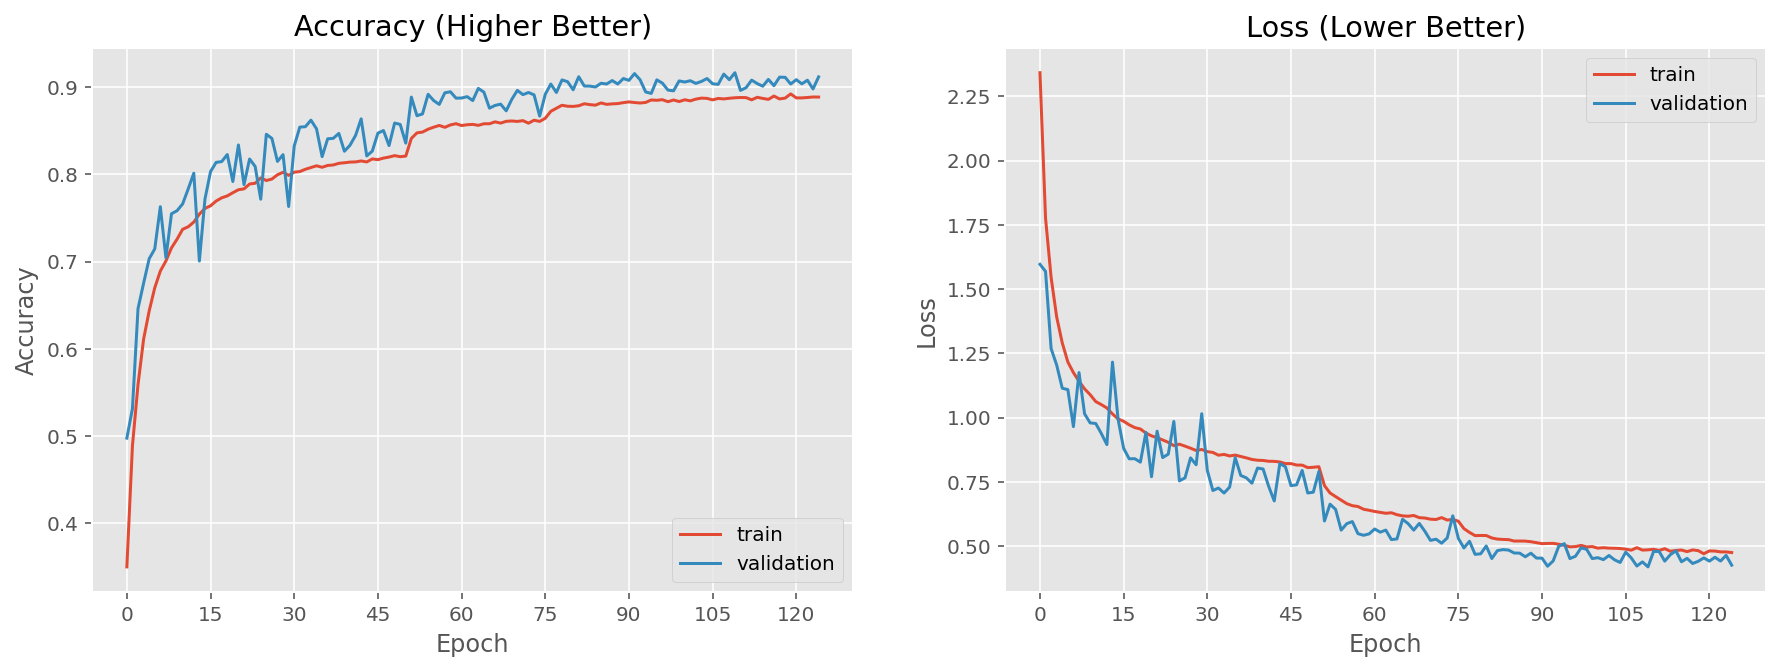

In [14]:

f, (plt1, plt2) = plt.subplots(1, 2,figsize=(15,5))

plt1.plot(history.history['accuracy'])
plt1.plot(history.history['val_accuracy'])
plt1.set_title('Accuracy (Higher Better)')
plt1.set(xlabel='Epoch', ylabel='Accuracy')
plt1.legend(['train', 'validation'], loc='lower right')
plt1.xaxis.set_major_locator(MaxNLocator(integer=True))

plt2.plot(history.history['loss'])
plt2.plot(history.history['val_loss'])
plt2.set_title('Loss (Lower Better)')
plt2.set(xlabel='Epoch', ylabel='Loss')
plt2.legend(['train', 'validation'], loc='upper right')
plt2.xaxis.set_major_locator(MaxNLocator(integer=True))


In [15]:
saved_model_dir = 'saved_model'
tf.saved_model.save(model, saved_model_dir)
 
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()
 
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: saved_model/assets


In [16]:
output = model.predict_classes(x_test)
print (output)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[3 8 8 ... 5 1 7]


In [17]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = y_train.reshape(y_train.shape[0])
y_test = y_test.reshape(y_test.shape[0])
ind = np.where(np.equal(output, y_test)==0)

In [18]:
err_x = x_test[ind[0]]
err_y = output[ind[0]]
print (err_x.shape)

(879, 32, 32, 3)


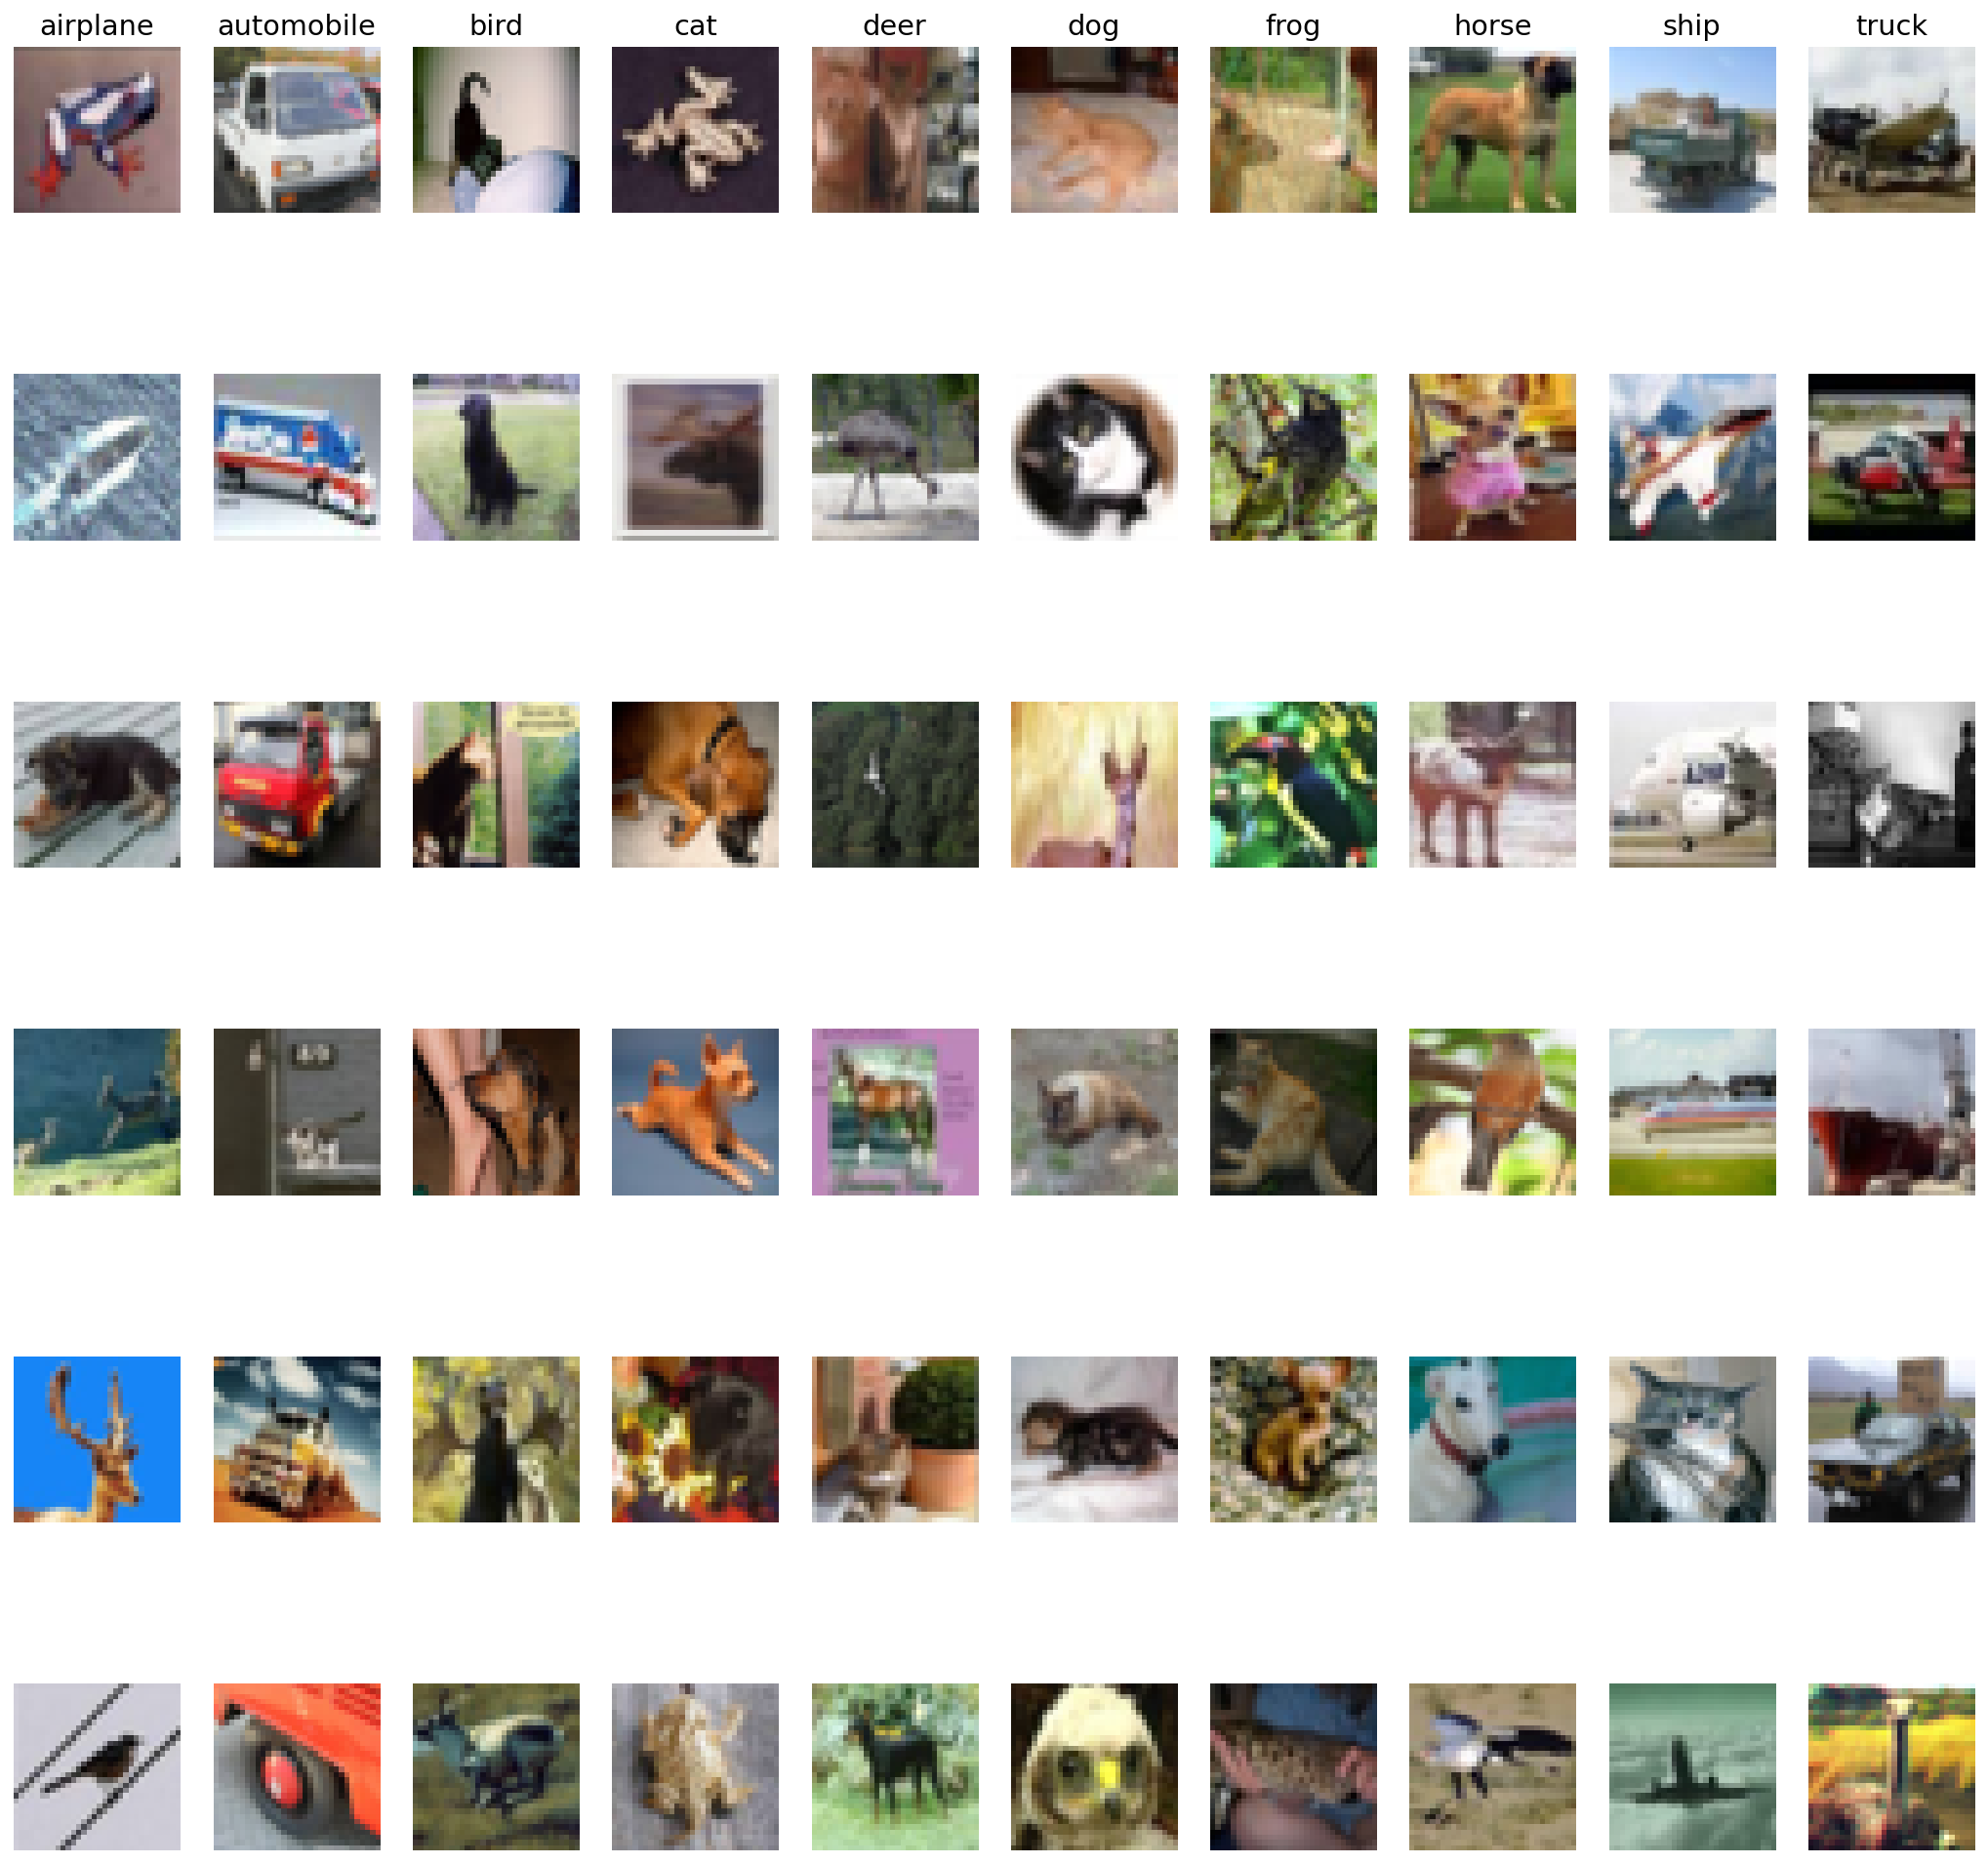

In [19]:
examples_per_class = 6
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(18,18))
for cls, cls_name in enumerate(class_names):
  idxs = np.where(cls == err_y)
  idxs = np.random.choice(idxs[0], examples_per_class, replace=False)
  for i, idx in enumerate(idxs):
    plt.subplot(examples_per_class, len(class_names), i * len(class_names) + cls + 1)
    plt.imshow(err_x[idx].astype('uint8'), cmap = 'gray')
    plt.axis('off')
    if i == 0:
      plt.title(cls_name)
plt.show()

